## What is a Genetic Algorithm?

It is a optimization algorithm inspired on the ideia of Evolution of Species through Natural Selection.
There basic parts of it are::
- Initial population: set of individuals wtih different caractheristics.
- Fitness function: a way to evaluate how fitted for survival each indidual is.
- Selection: step of selecting the fittest individuals that will pass genes to the next generation.
- Crossover: mixture of the genes from each parent individual.
- Mutation: random mutations that occur in the offspring



A pseudo algorithm could be:
1. set convergence rule
1. current population = initial population
1. while not converged: 
    1. calculate fitness score of each individual in current population
    1. select fittest
    1. set offspring = crossover of fittest
    1. do mutation step to offspring
    1. current population = offspring


In [3]:
import numpy as np
from string import ascii_letters
from tqdm.cli import tqdm

In [4]:
SOLUTION = np.array(tuple("Hello World"))

# each individual is a string of letters
POP_SIZE = 100
GENES = np.array(tuple(ascii_letters + " ")) # set of possible genes
GENES_SIZE = len(GENES) # set size
CHROMOSOME_SIZE = len(SOLUTION) # number of genes in  each individual

MATING_PROP = 0.20 # selects top 20% fittest
MATING_N = int(POP_SIZE * MATING_PROP)

MUTATION_PROB = 0.1

In [5]:


class Individual():

    def __init__(self, chromosome: np.ndarray = None):

        if chromosome is None:
            chromosome = np.random.choice(GENES, size = CHROMOSOME_SIZE)
        else:
            chromosome = np.array(chromosome)
        
        self.chromosome = chromosome
        self.size = chromosome.size
    
    def __repr__(self):
        return ''.join(self.chromosome)
    
    
    def mate(self, other):

        picks = np.random.randint(2, size=self.size).astype(bool)

        child1 = np.choose(picks, choices=[self.chromosome, other.chromosome])
        child2 = np.choose(~picks, choices=[self.chromosome, other.chromosome])

        return np.array((Individual(child1), Individual(child2)))
    
    def mutate(self, mutate_prob=MUTATION_PROB):
        # sequence of bernoulli's
        chromosome_picks = np.random.binomial(1, p=mutate_prob, size=self.size).astype(bool)
        n_mutations = np.sum(chromosome_picks)

        new_chromosome = self.chromosome.copy()

        if n_mutations:
            genes_picks = np.random.randint(GENES_SIZE, size=n_mutations)
            new_chromosome[chromosome_picks] = GENES[genes_picks]

        return Individual(new_chromosome)




class Population():

    def __init__(self, pop=None, size=None):
        if pop is not None:
            pass
        elif size is not None:
            pop = [Individual() for _ in range(size)]
        else:
            raise ValueError("One of pop or size should not be None.")
        self.pop = np.array(pop)
        self.size = len(pop)

        self.fitness_score = None
        self.fittests_rank = None

    def calc_fitness_scores(self, objective, *args, **kwargs):
        fitness_score = np.array([objective(x, *args, **kwargs) for x in self.pop])
        self.fitness_score = fitness_score
        return fitness_score

    def calc_fittests_rank(self):
        scores = self.fitness_score
        fittests_rank = np.argsort(-scores)
        #handle score ties
        #rnd = np.random.random(scores.size)
        #self.fittests_rank = np.array(np.lexsort((rnd, scores)))
        self.fittests_rank = fittests_rank
        return fittests_rank
    
    def select_top_fittests(self, p=None, n=MATING_N):
        if not (p or n): raise ValueError()
        elif p: n = int(p * self.size)
        idx_fittests = self.fittests_rank
        idx_top_fittest = idx_fittests[:n]
        return Population(self.pop[idx_top_fittest].copy())
    

    def mate_randomly(self, new_pop_size):
        #new_pop_size = self.size
        n_pairs = np.ceil(new_pop_size/2).astype(int)
        parents1, parents2 = np.random.choice(self.pop, size=(2,n_pairs))
        
        offspring = np.array([x.mate(y) for x, y in zip(parents1, parents2)]).flatten()[:new_pop_size].copy()
        
        return Population(offspring)

    def mutate(self, mutate_prob=MUTATION_PROB):
        return Population([x.mutate(mutate_prob=mutate_prob) for x in self.pop])

    






<AxesSubplot:xlabel='gen', ylabel='best_score'>

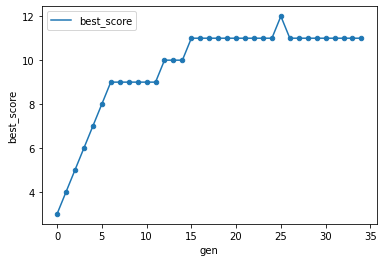

In [59]:
# objective fun
def func_fitness(x):
    return 1 + np.sum(x.chromosome == SOLUTION)



def has_converged(best_scores, gen, gen_limit, delta_gen, min_diff):
    
    if gen > gen_limit:
        return True
    
    if gen >= delta_gen:
        last_score = best_scores[-1]
        nth_score = best_scores[-delta_gen]
        diff = last_score - nth_score

        #print(f"#{gen}: {last_score}, #{gen-delta_gen}: {nth_score}, diff: {diff}")

        if abs(diff) <= min_diff:
            return True

    return False
    

GEN_LIMIT = 100
best_scores=[]
metrics = []
gen=0
pop = Population(size=POP_SIZE)
while not has_converged(best_scores, gen, gen_limit=GEN_LIMIT, delta_gen=20, min_diff=0):
    
    # 1. calculate fitness score of each individual in current population
    pop_scores = pop.calc_fitness_scores(func_fitness)
    idx_order = pop.calc_fittests_rank()
    
    # store metrics about generation
    best_score = pop_scores[idx_order[0]]
    best_scores.append(best_score)

    metrics.append(dict(
        gen=gen,
        best_individual=pop.pop[idx_order[0]],
        best_score=best_score,
    ))

    # 1. select
    mating_pop = pop.select_top_fittests(n = MATING_N)

    # 1. crossover
    pop = mating_pop.mate_randomly(pop.size)
    
    # 1. mutate
    pop = pop.mutate(mutate_prob=MUTATION_PROB)

    gen+=1


import pandas as pd
import matplotlib.pyplot as plt

dfmetrics = pd.DataFrame(metrics)

ax = dfmetrics.plot.line('gen','best_score')
dfmetrics.plot.scatter('gen','best_score', ax=ax)